## Self Attention

In [1]:
import torch
import torch.nn.functional as F

class SelfAttention(torch.nn.Module):
    
    def __init__(self, embedding_size:int = 4, dim_out: int = 4):
        super().__init__()
        self.wq = torch.nn.Linear(embedding_size, dim_out, bias=False)
        self.wk = torch.nn.Linear(embedding_size, dim_out, bias=False)
        self.wv = torch.nn.Linear(embedding_size, dim_out, bias=False)
        self.dim_out = dim_out

    def forward(self, embeddings):

        query = self.wq(embeddings)
        key = self.wk(embeddings)
        value = self.wv(embeddings)

        #print(query.shape, key.shape, key.transpose(1, 2).shape)

        sims = query @ key.transpose(1, 2)
        scaled_sim = torch.softmax(sims / (self.dim_out ** 0.5), dim=1)

        return scaled_sim @ value


In [2]:
torch.manual_seed(1)
embeddings = torch.nn.Embedding(1000, embedding_dim=4)
attention = SelfAttention(embedding_size=4, dim_out=4)

token_ids = torch.tensor([1, 2, 3])
encodings = embeddings(token_ids)

encodings, encodings.shape

(tensor([[-0.1002, -0.6092, -0.9798, -1.6091],
         [-0.7121,  0.3037, -0.7773, -0.2515],
         [-0.2223,  1.6871,  0.2284,  0.4676]], grad_fn=<EmbeddingBackward0>),
 torch.Size([3, 4]))

In [3]:
# add batch dimension 
encodings = encodings.unsqueeze(0)

attention(encodings)

tensor([[[ 0.4988, -0.0794, -0.1961, -0.1125],
         [ 0.3090, -0.0089, -0.1176, -0.1369],
         [ 0.1714,  0.0687, -0.0565, -0.1875]]], grad_fn=<UnsafeViewBackward0>)

In [4]:
torch.manual_seed(42)

attention = SelfAttention(embedding_size=2, dim_out=2)
encodings = torch.tensor([[1.16, 0.23],
                          [0.57, 1.36],
                          [4.41, -2.16]])

encodings = encodings.unsqueeze(dim=0)
attention(encodings)

tensor([[[0.1938, 0.4927],
         [0.0168, 0.4322],
         [3.9125, 2.7733]]], grad_fn=<UnsafeViewBackward0>)

#### Check Step by step calculation

In [5]:
attention.wq.weight.T

tensor([[ 0.5406, -0.1657],
        [ 0.5869,  0.6496]], grad_fn=<PermuteBackward0>)

In [6]:
attention.wk.weight.T

tensor([[-0.1549, -0.3443],
        [ 0.1427,  0.4153]], grad_fn=<PermuteBackward0>)

In [7]:
attention.wv.weight.T

tensor([[ 0.6233,  0.6146],
        [-0.5188,  0.1323]], grad_fn=<PermuteBackward0>)

In [8]:
q = attention.wq(encodings)
q

tensor([[[ 0.7621, -0.0428],
         [ 1.1063,  0.7890],
         [ 1.1164, -2.1336]]], grad_fn=<UnsafeViewBackward0>)

In [9]:
k = attention.wk(encodings)
k

tensor([[[-0.1469, -0.3038],
         [ 0.1057,  0.3685],
         [-0.9914, -2.4152]]], grad_fn=<UnsafeViewBackward0>)

In [12]:
sims = torch.matmul(q, k.transpose(1, 2))
sims

tensor([[[-0.0990,  0.0648, -0.6523],
         [-0.4022,  0.4078, -3.0024],
         [ 0.4842, -0.6683,  4.0461]]], grad_fn=<UnsafeViewBackward0>)

In [13]:
scaled_sim = F.softmax(sims / (torch.tensor(2) ** 0.5), dim=1)
scaled_sim

tensor([[[0.3014, 0.3484, 0.0346],
         [0.2433, 0.4441, 0.0066],
         [0.4553, 0.2075, 0.9588]]], grad_fn=<SoftmaxBackward0>)

In [14]:
torch.matmul(scaled_sim, attention.wv(encodings))

tensor([[[0.1938, 0.4927],
         [0.0168, 0.4322],
         [3.9125, 2.7733]]], grad_fn=<UnsafeViewBackward0>)

### Hiding Future words with causal attention

* In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight.

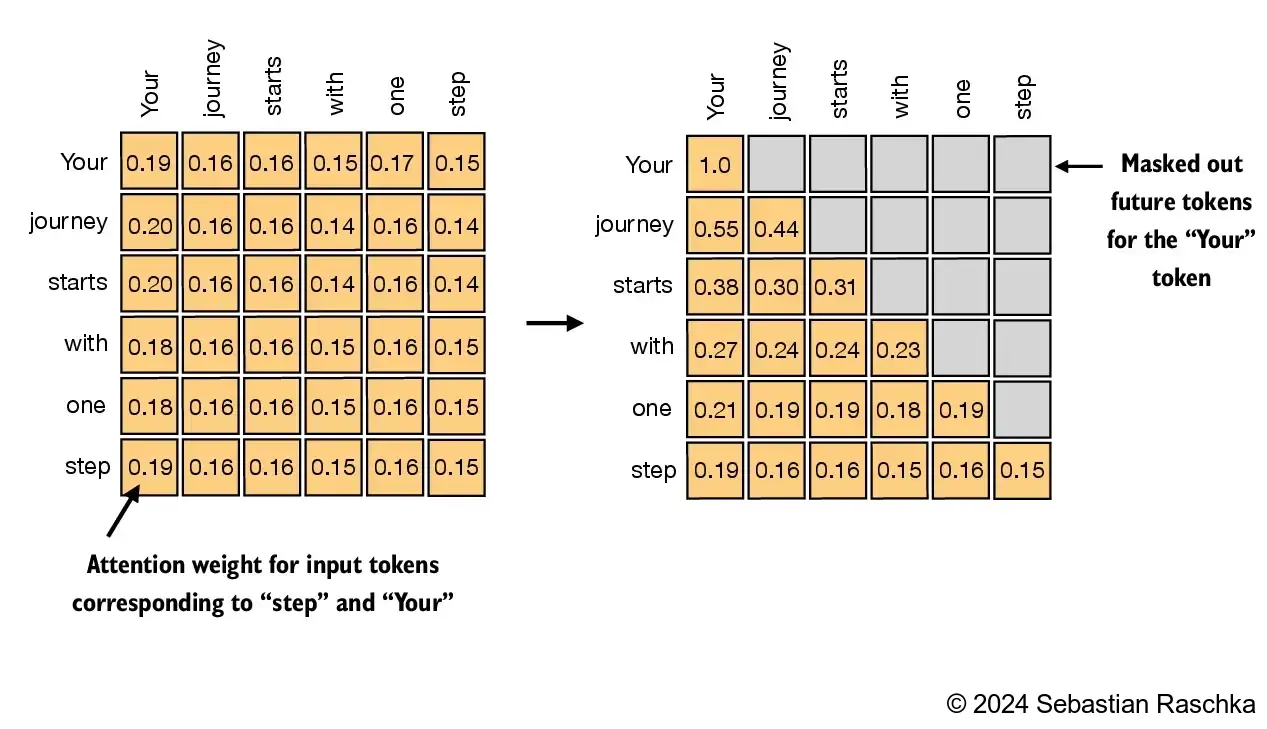

In [9]:
from IPython.display import Image
Image(filename="./images/causal_attention.png", width=400, height=150)

* In this section, we are converting the previous self-attention mechanism into a causal self-attention mechanism
* Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions
* In simpler words, this ensures that each next word prediction should only depend on the preceding words
* To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text)

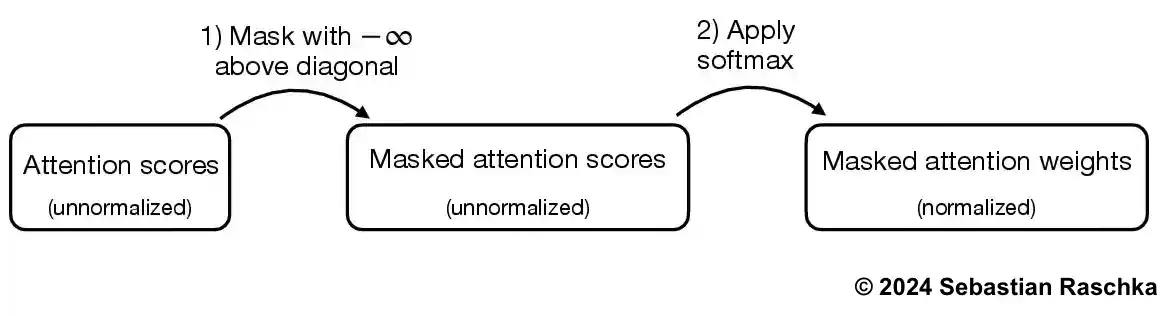

In [12]:
from IPython.display import Image
Image(filename="./images/causal_attention_steps.png", width=600, height=150)

In [14]:
torch.triu(torch.ones(5, 5), diagonal=1)

tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [31]:
class CausalSelfAttention(torch.nn.Module):
    
    def __init__(self, embedding_size:int = 4, dim_out: int = 4, drop_out=0.2, context_length: int = 256):
        super().__init__()
        self.wq = torch.nn.Linear(embedding_size, dim_out, bias=False)
        self.wk = torch.nn.Linear(embedding_size, dim_out, bias=False)
        self.wv = torch.nn.Linear(embedding_size, dim_out, bias=False)
        self.dim_out = dim_out
        self.dropout = torch.nn.Dropout(drop_out)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, embeddings):
        b, num_tokens, d_in = embeddings.shape

        query = self.wq(embeddings)
        key = self.wk(embeddings)
        value = self.wv(embeddings)

        attn_scores = query @ key.transpose(1, 2)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (self.dim_out ** 0.5), dim=-1)

        attn_weights = self.dropout(attn_weights)

        context_vec = torch.matmul(attn_weights, value)
        return context_vec

In [32]:
torch.manual_seed(42)

attention = CausalSelfAttention(embedding_size=2, 
                                dim_out=2, context_length=10)

encodings = torch.tensor([[1.16, 0.23],
                          [0.57, 1.36],
                          [4.41, -2.16]])

encodings = encodings.unsqueeze(dim=0) # add batch dim
attention(encodings)

tensor([[[ 0.7547,  0.9292],
         [-0.0077,  0.7589],
         [ 0.0405,  0.0883]]], grad_fn=<UnsafeViewBackward0>)

## MultiHead Attention

* The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [28]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, embedding_size:int = 4, dim_out:int = 4, num_heads: int = 4):
        super().__init__()
        self.heads = torch.nn.ModuleList([CausalSelfAttention(embedding_size, dim_out) for _ in range(num_heads) 
                                          ])
    def forward(self, embeddings):
        return torch.cat([head(embeddings) for head in self.heads], dim=1)

In [30]:
torch.manual_seed(42)
attention = MultiHeadAttention(embedding_size=2, dim_out=2, num_heads=2)
encodings = torch.tensor([[1.16, 0.23],
                          [0.57, 1.36],
                          [4.41, -2.16]])

encodings = encodings.unsqueeze(dim=0) # add batch dim
attention(encodings)

tensor([[[ 0.7547,  0.9292],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.2537, -0.1440],
         [-0.7659, -0.9805]]], grad_fn=<CatBackward0>)